In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina' # plt 화질 up
print("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("devicde :[%s]."%(device))

PyTorch version:[1.10.0+cu111].
devicde :[cuda:0].


In [28]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
print("mnist_train : \n", mnist_train, "\n")
print("mnist_test : \n", mnist_test, "\n")
print("Done.")

mnist_train : 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test : 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


In [38]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print("Done.")

Done.


In [30]:
class MultiLayerPerceptronClass(nn.Module):

    def __init__(self, name='mlp', xdim=784, hdim=256, ydim=10): # x : input, h : hidden, output : 10
        super(MultiLayerPerceptronClass, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)
        self.init_param()

    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight) 
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp', xdim=784, hdim=256, ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(), lr=1e-3)
print("Done.")

Done.


In [31]:
# simple forward
x_numpy = np.random.rand(2, 784)  # input
x_torch = torch.from_numpy(x_numpy).float().to(device) # input numpy -> torch
y_torch = M.forward(x_torch) # forward
y_numpy = y_torch.detach().cpu().numpy() # output torch -> numpy
print("x_numpy:\n", x_numpy)
print("x_torch:\n", x_torch)
print("y_torch:\n", y_torch)
print("y_numpy:\n", y_numpy)


x_numpy:
 [[0.572 0.005 0.697 ... 0.797 0.462 0.222]
 [0.223 0.586 0.466 ... 0.903 0.151 0.194]]
x_torch:
 tensor([[0.5723, 0.0054, 0.6970,  ..., 0.7968, 0.4618, 0.2221],
        [0.2233, 0.5857, 0.4664,  ..., 0.9034, 0.1511, 0.1940]],
       device='cuda:0')
y_torch:
 tensor([[-1.0568, -0.9197, -0.9401, -1.4326, -0.1896, -0.5811, -0.8768, -0.9317,
          1.1449, -1.2750],
        [-0.5242, -0.6600, -0.8377, -0.8823, -0.0031,  0.0516, -1.0304,  0.0072,
          1.3436, -1.2194]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_numpy:
 [[-1.057 -0.92  -0.94  -1.433 -0.19  -0.581 -0.877 -0.932  1.145 -1.275]
 [-0.524 -0.66  -0.838 -0.882 -0.003  0.052 -1.03   0.007  1.344 -1.219]]


In [32]:
# check parameter
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(M.named_parameters()):
    param_numpy  = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print("[%d] name : [%s] shape:[%s]"%(p_idx, param_name, param_numpy.shape))
    print("      val : %s"%(param_numpy.reshape(-1)[:5]))

print("Total number of parameters:[%s]."%(format(n_param,'d')))

[0] name : [lin_1.weight] shape:[(256, 784)]
      val : [ 0.062 -0.017  0.031 -0.031 -0.062]
[1] name : [lin_1.bias] shape:[(256,)]
      val : [0. 0. 0. 0. 0.]
[2] name : [lin_2.weight] shape:[(10, 256)]
      val : [0.019 0.005 0.036 0.108 0.008]
[3] name : [lin_2.bias] shape:[(10,)]
      val : [0. 0. 0. 0. 0.]
Total number of parameters:[203530].


In [34]:
# evaluation function
def func_eval(model, data_iter, device):
    with torch.no_grad(): # gradient를 계산하지 않겠다
        model.eval() # evaluate mode (off dropout and batch nomalization)
        n_total, n_correct = 0,0
        for batch_in, batch_out in data_iter:
            y_target = batch_out.to(device)
            model_pred = model(batch_in.view(-1,28*28).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            n_correct += (y_pred==y_target).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode (on dropout and batch nomalization)
    return val_accr

In [41]:
# Initial Evaluation
# M.init_param()
train_acc = func_eval(M, train_iter, device)
test_acc = func_eval(M, test_iter, device)
print("train_accr:[%.3f] test_accr:[%.3f]"%(train_acc, test_acc))

train_accr:[0.113] test_accr:[0.112]


In [42]:
# Train
print("Start training.")
M.init_param() # initialize parameters
M.train()

EPOCHS, print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        y_pred = M.forward(batch_in.view(-1,28*28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        #update
        optm.zero_grad() # reset grdient
        loss_out.backward() # back prop
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_acc = func_eval(M, train_iter, device)
        test_acc = func_eval(M, test_iter, device)
        print("epoch:[%d] loss:[%.3f] train_acc:[%.3f] test_acc[%.3f]."%
               (epoch, loss_val_avg, train_acc, test_acc))
        
print("done")

Start training.
epoch:[0] loss:[0.364] train_acc:[0.946] test_acc[0.946].
epoch:[1] loss:[0.162] train_acc:[0.965] test_acc[0.962].
epoch:[2] loss:[0.117] train_acc:[0.975] test_acc[0.969].
epoch:[3] loss:[0.089] train_acc:[0.982] test_acc[0.971].
epoch:[4] loss:[0.071] train_acc:[0.985] test_acc[0.975].
epoch:[5] loss:[0.058] train_acc:[0.988] test_acc[0.975].
epoch:[6] loss:[0.048] train_acc:[0.989] test_acc[0.977].
epoch:[7] loss:[0.041] train_acc:[0.993] test_acc[0.979].
epoch:[8] loss:[0.033] train_acc:[0.993] test_acc[0.979].
epoch:[9] loss:[0.028] train_acc:[0.996] test_acc[0.980].
done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


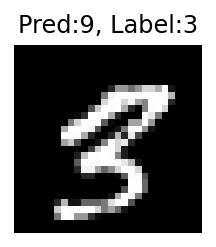

done


In [48]:
# predcition test
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data#[sample_indices]
test_y = mnist_test.targets#[sample_indices]

with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(len(mnist_test.targets)):
    plot_idx = 0
    if y_pred[idx] != test_y[idx]:
        plt.subplot(5,5,plot_idx+1)
        plt.imshow(test_x[idx], cmap='gray')
        plt.axis('off')
        plt.title('Pred:%d, Label:%d'%(y_pred[idx], test_y[idx]))
        plot_idx += 1
plt.show()
print("done")